# 1. Point Cloud Registration Using ICP

## Import Dataset

In [1]:
!pip install -q gdown

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# کپی فایل به محیط محلی Colab
!cp "/content/drive/MyDrive/Colab Notebooks/3D Computer Vision/kitti_sample.zip" "/content/"
!unzip "/content/kitti_sample.zip" -d "/content/kitti_sample"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/kitti_sample.zip
replace /content/kitti_sample/kitti_sample/00/000000.bin? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Show Lidar Points

تعداد کل نقاط در فایل: 124605


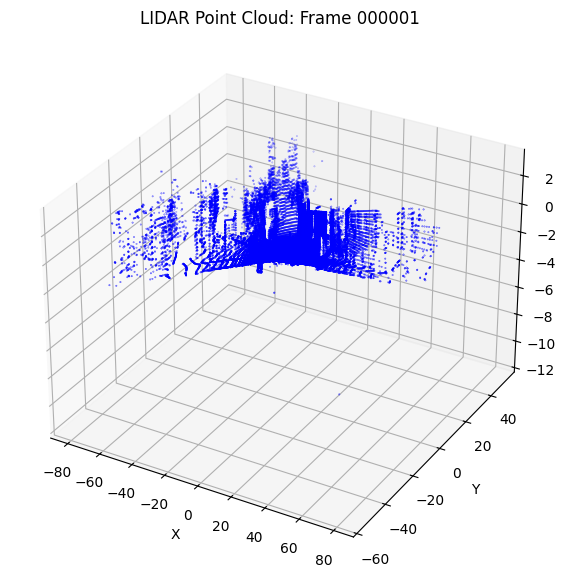

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# مسیر فایل point cloud
bin_path = "/content/kitti_sample/kitti_sample/00/000001.bin"

# خواندن داده‌ها از فایل باینری
point_cloud = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
points = point_cloud[:, :3]  # جدا کردن x, y, z

# ✅ چاپ تعداد نقاط
print(f"تعداد کل نقاط در فایل: {points.shape[0]}")

# رسم با matplotlib
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2],
           c='blue', s=0.1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("LIDAR Point Cloud: Frame 000001")
plt.show()


## (a) Select Two Point Clouds:

In [4]:
!pip install -q open3d

In [5]:
import open3d as o3d

def load_bin_to_pcd(bin_path):
    """خواندن فایل .bin و تبدیل به point cloud از نوع Open3D"""
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

# مسیر فایل‌ها
base_path = "/content/kitti_sample/kitti_sample/00/"
source_pcd = load_bin_to_pcd(base_path + "000001.bin")
target_pcd = load_bin_to_pcd(base_path + "000005.bin")

# ✅ downsampling برای افزایش سرعت و کاهش نویز
voxel_size = 0.5  # می‌تونی 0.2 هم امتحان کنی
source_down = source_pcd.voxel_down_sample(voxel_size)
target_down = target_pcd.voxel_down_sample(voxel_size)

# ✅ تخمین نرمال‌ها برای ICP point-to-plane (اختیاری)
source_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
target_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))


## (b) Visualize Unregistered Point Clouds:

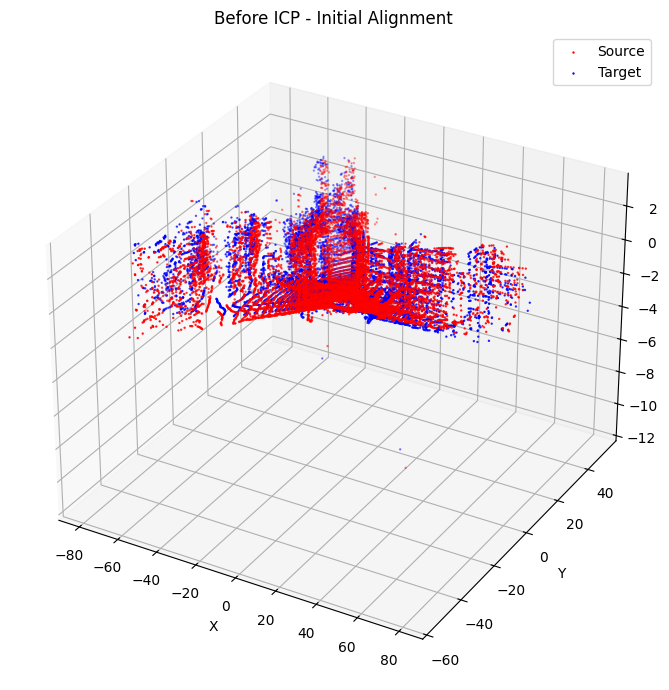

In [6]:
def plot_before_icp(source, target, title="Before ICP - Initial Alignment"):
    # تبدیل به numpy
    source_points = np.asarray(source.points)
    target_points = np.asarray(target.points)

    # رسم نمودار
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(source_points[:, 0], source_points[:, 1], source_points[:, 2],
               c='red', s=0.5, label='Source')
    ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2],
               c='blue', s=0.5, label='Target')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# اجرای تابع:
plot_before_icp(source_down, target_down)

## (c) Apply ICP Algorithm:

In [7]:
# اجرای ICP Point-to-Point
icp_result = o3d.pipelines.registration.registration_icp(
    source_down,  # ابرنقطه‌ی منبع
    target_down,  # ابرنقطه‌ی هدف
    max_correspondence_distance=1.0,  # بیشترین فاصله‌ی ممکن برای تطابق
    init=np.eye(4),  # تبدیل اولیه (ایندکس هم‌راستا)
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
)

# ✅ چاپ خروجی
print("Transformation matrix (ICP):\n", icp_result.transformation)
print("Fitness:", icp_result.fitness)
print("Inlier RMSE:", icp_result.inlier_rmse)

Transformation matrix (ICP):
 [[ 0.99990311  0.01380751  0.00176822 -1.03774161]
 [-0.01380418  0.99990295 -0.00188165  0.00165326]
 [-0.00179403  0.00185706  0.99999667  0.00996909]
 [ 0.          0.          0.          1.        ]]
Fitness: 0.7087866108786611
Inlier RMSE: 0.5061625714170958


## (d) Visualize Aligned Point Clouds:

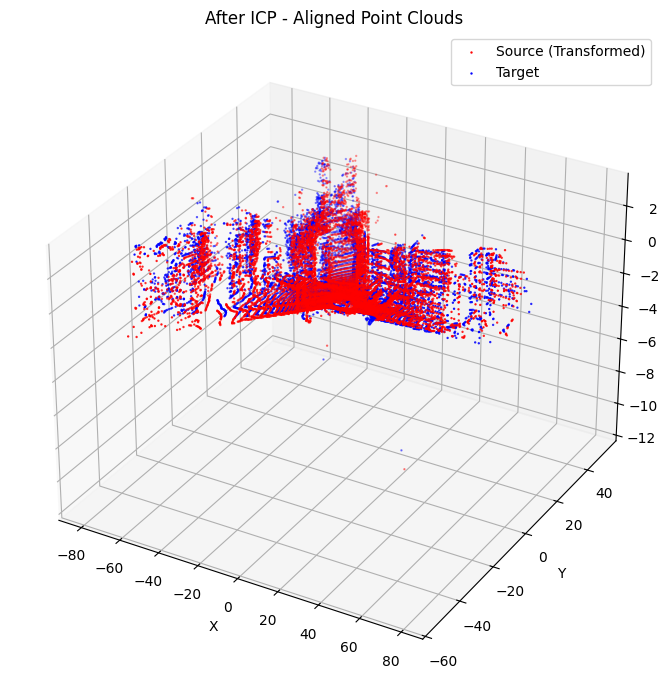

In [8]:
def plot_after_icp(source, target, transformation, title="After ICP - Aligned Point Clouds"):
    # اعمال تبدیل به Source
    source_transformed = source.transform(transformation.copy())

    # تبدیل به numpy array
    src_pts = np.asarray(source_transformed.points)
    tgt_pts = np.asarray(target.points)

    # رسم
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(src_pts[:, 0], src_pts[:, 1], src_pts[:, 2], c='red', s=0.5, label='Source (Transformed)')
    ax.scatter(tgt_pts[:, 0], tgt_pts[:, 1], tgt_pts[:, 2], c='blue', s=0.5, label='Target')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

# اجرای تابع
plot_after_icp(source_down, target_down, icp_result.transformation)

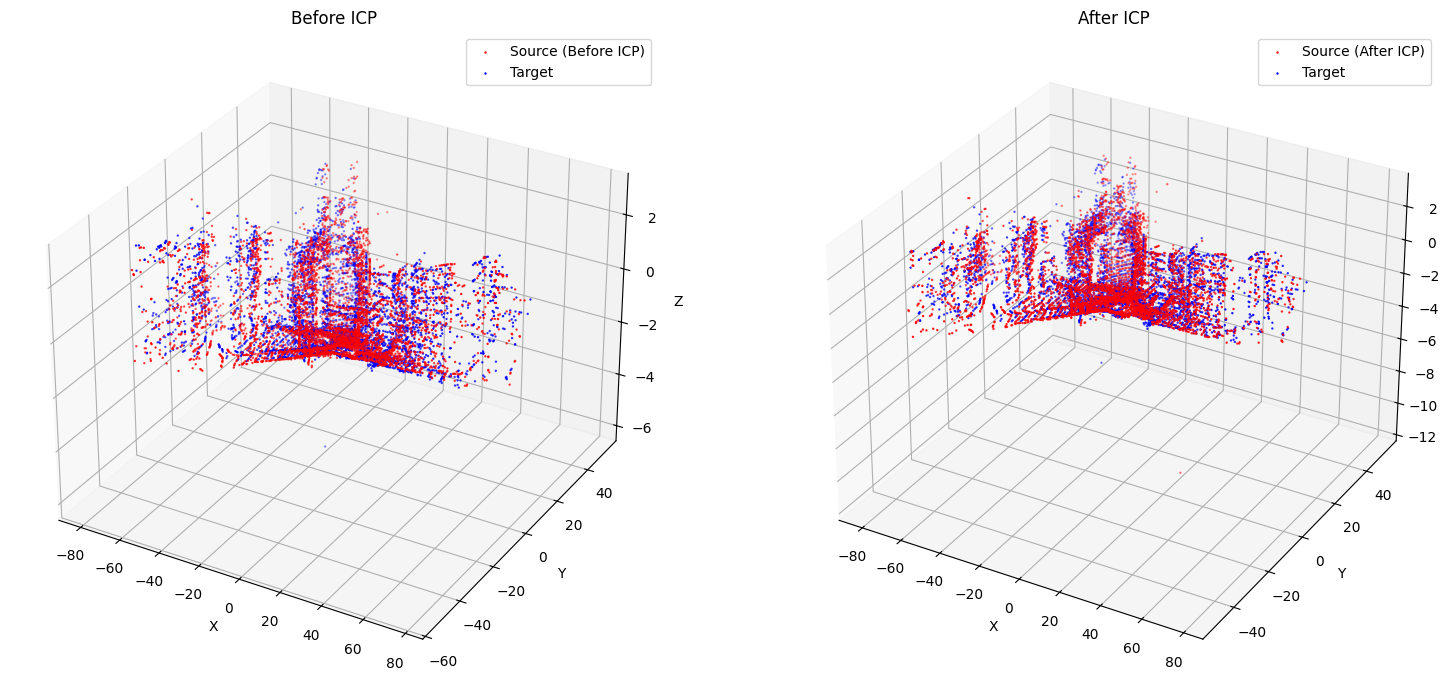

In [9]:
import copy

def plot_before_after_icp_side_by_side(source, target, transformation, sample_size=5000):
    # تبدیل به numpy
    src_points = np.asarray(source.points)
    tgt_points = np.asarray(target.points)

    # اعمال تبدیل روی نسخه‌ی کپی از Source
    source_transformed = copy.deepcopy(source)
    source_transformed.transform(transformation.copy())
    src_transformed_points = np.asarray(source_transformed.points)

    # نمونه‌گیری اختیاری (برای سبک کردن رسم)
    def sample(pts):
        if pts.shape[0] > sample_size:
            idx = np.random.choice(pts.shape[0], sample_size, replace=False)
            return pts[idx]
        return pts

    src_sampled = sample(src_points)
    tgt_sampled = sample(tgt_points)
    src_transformed_sampled = sample(src_transformed_points)

    # رسم
    fig = plt.figure(figsize=(16, 7))

    # subplot 1: قبل از ICP
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(src_sampled[:, 0], src_sampled[:, 1], src_sampled[:, 2], c='red', s=0.5, label='Source (Before ICP)')
    ax1.scatter(tgt_sampled[:, 0], tgt_sampled[:, 1], tgt_sampled[:, 2], c='blue', s=0.5, label='Target')
    ax1.set_title("Before ICP")
    ax1.set_xlabel('X'); ax1.set_ylabel('Y'); ax1.set_zlabel('Z')
    ax1.legend()

    # subplot 2: بعد از ICP
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.scatter(src_transformed_sampled[:, 0], src_transformed_sampled[:, 1], src_transformed_sampled[:, 2], c='red', s=0.5, label='Source (After ICP)')
    ax2.scatter(tgt_sampled[:, 0], tgt_sampled[:, 1], tgt_sampled[:, 2], c='blue', s=0.5, label='Target')
    ax2.set_title("After ICP")
    ax2.set_xlabel('X'); ax2.set_ylabel('Y'); ax2.set_zlabel('Z')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# اجرای تابع
plot_before_after_icp_side_by_side(source_down, target_down, icp_result.transformation)


# 2. Incremental Registration of Multiple Point Clouds Using ICP

## (a) Use the Result from Previous Part:

In [10]:
def load_bin_to_pcd(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd

def register_sequence_with_icp(folder_path, start_idx=1, end_idx=20, voxel_size=0.5):
    pose = np.eye(4)  # مقدار اولیه ماتریس تبدیل
    trajectory = [pose[:3, 3]]  # ذخیره موقعیت‌ها (فقط translation)

    # نقشه اولیه
    base_map = load_bin_to_pcd(f"{folder_path}/{start_idx:06d}.bin")
    base_map = base_map.voxel_down_sample(voxel_size)
    base_map.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    for idx in range(start_idx + 1, end_idx + 1):
        print(f"Processing frame {idx}...")

        # بارگذاری ابرنقطه جدید
        current_pcd = load_bin_to_pcd(f"{folder_path}/{idx:06d}.bin")
        current_down = current_pcd.voxel_down_sample(voxel_size)
        current_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

        # رجیستریشن با base_map
        icp_result = o3d.pipelines.registration.registration_icp(
            current_down, base_map,
            max_correspondence_distance=1.0,
            init=np.eye(4),
            estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
        )

        # به‌روز رسانی pose و trajectory
        pose = pose @ icp_result.transformation
        trajectory.append(pose[:3, 3])  # فقط translation

        # تبدیل current_pcd به مختصات جهانی و افزودن به نقشه
        current_pcd.transform(pose)
        base_map += current_pcd
        base_map = base_map.voxel_down_sample(voxel_size=0.3)  # دوباره downsample برای کنترل تعداد نقاط

    return base_map, np.array(trajectory)

# مسیر داده‌ها
data_path = "/content/kitti_sample/kitti_sample/00"

# اجرای ثبت توالی
map_pcd, traj = register_sequence_with_icp(data_path, start_idx=1, end_idx=15)


Processing frame 2...
Processing frame 3...
Processing frame 4...
Processing frame 5...
Processing frame 6...
Processing frame 7...
Processing frame 8...
Processing frame 9...
Processing frame 10...
Processing frame 11...
Processing frame 12...
Processing frame 13...
Processing frame 14...
Processing frame 15...


## (b) Visualize the Final Map:

In [11]:
base_path = "/content/kitti_sample/kitti_sample/00/"
start_frame = 1
end_frame = 136  # تا این شماره موجوده
step = 5

# لیست تبدیل‌ها و مسیر فعلی
transformations = []
poses = [np.eye(4)]  # لیست مسیرهای تجمیعی برای ترسیم مسیر

# مقدار اولیه (اولین فریم به عنوان نقشه پایه)
source_pcd = load_bin_to_pcd(base_path + f"{start_frame:06d}.bin")
source_down = source_pcd.voxel_down_sample(voxel_size)
source_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

for i in range(start_frame + step, end_frame + 1, step):
    target_pcd = load_bin_to_pcd(base_path + f"{i:06d}.bin")
    target_down = target_pcd.voxel_down_sample(voxel_size)
    target_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    # اجرای ICP: رجیستریشن بین source و target
    icp_result = o3d.pipelines.registration.registration_icp(
        target_down, source_down,
        max_correspondence_distance=1.0,
        init=np.eye(4),
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )

    # ذخیره تبدیل
    T = icp_result.transformation
    transformations.append(T)

    # بروزرسانی موقعیت تجمیعی
    current_pose = poses[-1] @ T
    poses.append(current_pose)

    # بروزرسانی نقشه پایه
    source_down = target_down

print(f"Collected {len(transformations)} ICP transformations.")


Collected 27 ICP transformations.


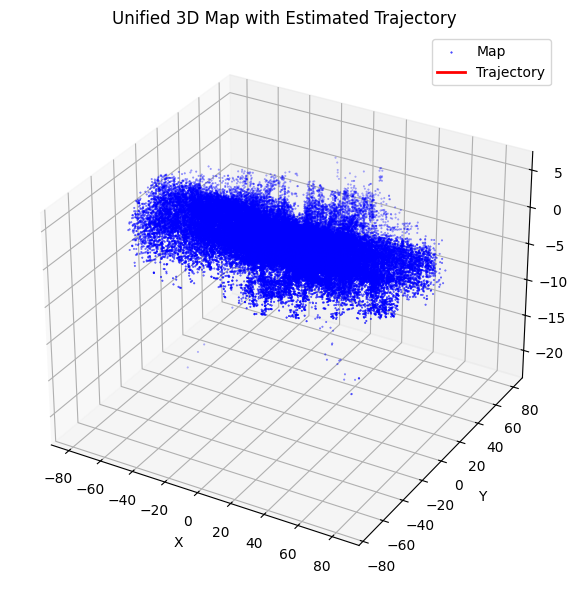

In [14]:
# ترکیب تمام فریم‌ها برای ساخت نقشه نهایی
combined_map = o3d.geometry.PointCloud()
for idx, pose in enumerate(poses):
    frame_id = start_frame + idx * step
    bin_path = base_path + f"{frame_id:06d}.bin"
    pcd = load_bin_to_pcd(bin_path)
    pcd_down = pcd.voxel_down_sample(voxel_size)
    pcd_down.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
    pcd_down.transform(pose)
    combined_map += pcd_down

def plot_final_map_with_trajectory(point_cloud, poses):
    # استخراج نقاط نقشه
    points = np.asarray(point_cloud.points)

    # نمونه‌گیری برای سبک‌سازی
    if points.shape[0] > 100000:
        idx = np.random.choice(points.shape[0], 100000, replace=False)
        points = points[idx]

    # استخراج مسیر حرکت از ماتریس‌های pose
    traj = np.array([pose[:3, 3] for pose in poses])

    # رسم
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # نقشه نهایی (آبی)
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.2, c='blue', label="Map")

    # مسیر حرکت (قرمز)
    ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], c='red', linewidth=2, label="Trajectory")
    ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], c='red', s=5)  # نقاط مسیر

    ax.set_title("Unified 3D Map with Estimated Trajectory")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    plt.tight_layout()
    plt.show()

# 📌 فراخوانی تابع
# شروع با ماتریس همانی (مبدأ مسیر)
all_poses = [np.eye(4)]

# اعمال تجمعی تبدیلات
for T in transformations:
    new_pose = all_poses[-1] @ T
    all_poses.append(new_pose)
plot_final_map_with_trajectory(combined_map, all_poses)


# 3. Point Cloud Registration Using NDT

## (a) Apply NDT Algorithm: